# Developing the Deep Learning Model for Upper Facial Gestures Generation

***Author: Martín Cepeda***

In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras


%matplotlib inline

Imported pydotplus


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


## Path setup

This section sets the relative paths to:

- Search for feature CSVs computed in Lab 1
- Set paths for saving model checkpoints and training history

In [3]:
here = os.getcwd()

video_dir = os.path.join(here, "data")
audio_dir = os.path.join(video_dir, "audios")
audio_features_dir = os.path.join(video_dir, "audio_features")
face_features_dir = os.path.join(video_dir, "face_features")

figures_dir = os.path.join(here, "figures", "lab1")
merged_features_dir = os.path.join(video_dir, "merged_features")
model_data_dir = os.path.join(video_dir, "clean_data")

video_ids = [os.path.split(file)[1][:-4] for file in glob(os.path.join(video_dir, "*.mp4"))]

debug_dir = os.path.join(here, "debug")
model_dir = os.path.join(debug_dir, "model")
history_dir = os.path.join(debug_dir, "history")

os.makedirs(model_dir, exist_ok=True)
os.makedirs(history_dir, exist_ok=True)

These 2 flags indicate:
- Whether a clean, merged CSV exists for audio and video features
- Whether the seq2seq model needs to be retrained (otherwise loads model weights from disk)

In [4]:
CLEAN_EXIST = True
RETRAIN = False

In [5]:
print('Available video IDs:')

video_ids

Available video IDs:


['k4vzhweOefs',
 'lr-mXnUoUXM',
 'O6jrLgvCUNs',
 'ovKqmRyOGcg',
 'psN1DORYYV0',
 'tZYkjaKNr_o',
 'XE_FPEFpHt4',
 'yCm9Ng0bbEQ',
 'zawpbVpu5nY',
 'ZdDjexbxVzM']

## Import data
We first read the merged dataframes computed in Lab 1 and we keep only relevant columns (F0 and other prosodic features for audio and Action Units intensity for video 

In [6]:
def read_merged_features(video_id, dir_=merged_features_dir):
    csv_path = os.path.join(merged_features_dir, f"{video_id}.csv")
    df = pd.read_csv(csv_path, 
                     sep=",", 
                     dtype={
                         "face_id": int,
                     })
    # Remove spaces from column names
    df.columns = df.columns.str.strip()
    # Extract only relevant features for TD2: F0, MFCC, Jitter, Shimmer, HNR, AUs 1 to 7
    cols_to_keep = ['timestamp', 'F0raw', 'F0final', 'mfcc[0]', 'mfcc[1]', 'mfcc[2]',
                    'mfcc[3]', 'mfcc[4]', 'mfcc[5]', 'mfcc[6]', 'mfcc[7]', 
                    'mfcc[8]', 'mfcc[9]', 'mfcc[10]', 'mfcc[11]', 'mfcc[12]', 
                    'mfcc[13]', 'mfcc[14]', 'jitterLocal', 'shimmerLocal', 'HNR', 
                    'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r']
    
    df = df[cols_to_keep]
    
    return df

Read and clean dataframes (according to the previously defined features)

In [7]:
dfs_merged = []
if not CLEAN_EXIST:
    print('Loading raw data, cleaning & saving...', flush=True)
    os.makedirs(model_data_dir, exist_ok=True)
    for video_id in tqdm(video_ids):
        df_i = read_merged_features(video_id)
        dfs_merged.append(df_i)
        
        csv_fname = f'{video_id}.csv'
        path_csv_i = os.path.join(model_data_dir, csv_fname)
        df_i.to_csv(path_csv_i, index=False)
else:
    print('Loading existing clean data...', flush=True)
    for video_id in tqdm(video_ids):
        df_i = read_merged_features(video_id, dir_=model_data_dir)
        dfs_merged.append(df_i)

Loading existing clean data...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:51<00:00, 11.16s/it]


In [8]:
print("Available features")
[print(f'\t{i}') for i in list(dfs_merged[0].columns)];
print("Video lengths (frames)")
[print(f'\t{video_ids[i]}: {len(df)}') for i, df in enumerate(dfs_merged)];

Available features
	timestamp
	F0raw
	F0final
	mfcc[0]
	mfcc[1]
	mfcc[2]
	mfcc[3]
	mfcc[4]
	mfcc[5]
	mfcc[6]
	mfcc[7]
	mfcc[8]
	mfcc[9]
	mfcc[10]
	mfcc[11]
	mfcc[12]
	mfcc[13]
	mfcc[14]
	jitterLocal
	shimmerLocal
	HNR
	AU01_r
	AU02_r
	AU04_r
	AU05_r
	AU06_r
	AU07_r
Video lengths (frames)
	k4vzhweOefs: 75901
	lr-mXnUoUXM: 74226
	O6jrLgvCUNs: 55754
	ovKqmRyOGcg: 26182
	psN1DORYYV0: 71402
	tZYkjaKNr_o: 40213
	XE_FPEFpHt4: 35541
	yCm9Ng0bbEQ: 56343
	zawpbVpu5nY: 43698
	ZdDjexbxVzM: 15395


## Preprocess data

For this Lab we'll work only with F0 as feature and we'll try to predict the Action units

In [9]:
AU_columns = ['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r']
STEP_SIZE_AU = 0.2
STEP_SIZE_F0 = 0.1
F0_COLUMN = 'F0final'

We define a quantization function for AU intensity following the formula:
$$Q_\Delta(x) = \Delta\cdot\left \lfloor{\frac{x}{\Delta}+\frac{1}{2}}\right \rfloor $$

Which rounds $x$ to the nearest multiple of $\Delta$

In [10]:
def quantize(x, step=0.1):
    assert step > 0.0
    return np.round(step*np.floor(x/step +0.5), 1)

We quantize AUs and F0 (and also clipping the latter between 50 and 550). We reset indexes in dataframes to proper slicing after

In [11]:
max_AU = 0.0
unique_f0 = set()
for i, video_id in enumerate(video_ids):
    df = dfs_merged[i]
    df[AU_columns] = df[AU_columns].applymap(lambda x: quantize(x, STEP_SIZE_AU))
    df[F0_COLUMN] = df[F0_COLUMN].apply(lambda x: quantize(np.clip(x, 50, 550), STEP_SIZE_F0))
    df.reset_index(drop=True, inplace=True)
    unique_f0 = unique_f0.union(df[F0_COLUMN].values)
    max_AU = max(max_AU, df[AU_columns].values.max())

Make ID_to_feature and ID_to_F0 dictionaries and their inverses in order to codify/decodify sequences

In [12]:
## AU processing
values_AU = np.array([np.around(i*STEP_SIZE_AU, 1) for i in range(int(max_AU/STEP_SIZE_AU)+1)])

ID_to_AU = {i+2: value for i, value in enumerate(values_AU)}
ID_to_AU[0] = 'SOS'
ID_to_AU[1] = 'EOS'
ID_to_AU = dict(sorted(ID_to_AU.items(), key=lambda item: item[0]))   

one_hots_AU = keras.utils.to_categorical(range(len(values_AU)))

# Make reverse_search dictionaries
AU_to_ID = {v:k for k, v in ID_to_AU.items()}

## F0 processing
ID_to_F0 = {i+2: value for i, value in enumerate(sorted(list(unique_f0)))}
ID_to_F0[0] = 'SOS'
ID_to_F0[1] = 'EOS'
ID_to_F0 = dict(sorted(ID_to_F0.items(), key=lambda item: item[0]))

F0_to_ID = {v:k for k, v in ID_to_F0.items()}

# one_hots_F0 = keras.utils.to_categorical(range(len(unique_f0)))

We make sequences from the different videos. Each sequence has a fixed lenght `SEQ_LEN` and a fixed overlap length with its neighbors `SEQ_OVERLAP`. In case of bad multiplicity, we pad last sequence until `SEQ_LEN`

In [13]:
SEQ_LEN = 100
SEQ_OVERLAP = 20

FEATURE_COLS = ['F0final']

sequences_features = []
sequences_predict = []
for df in dfs_merged:
    l = len(df)
    current_i = 0
    while current_i + SEQ_LEN <= l:
        # Sequence limits
        id_i = current_i
        id_f = current_i + SEQ_LEN
        # Update current i
        current_i = current_i + SEQ_LEN - SEQ_OVERLAP 
        
        # Get data
        sequences_features.append(df[id_i:id_f][FEATURE_COLS].values)
        sequences_predict.append(df[id_i:id_f][AU_columns].values)   
    
    # Handle last window with padding
    if current_i != l - SEQ_OVERLAP:
        last_frame_features = np.zeros((SEQ_LEN, len(FEATURE_COLS)))
        last_frame_predict = np.zeros((SEQ_LEN, len(AU_columns)))
        
        last_frame_features[:l-current_i, :] = df[current_i:][FEATURE_COLS].values
        last_frame_predict[:l-current_i, :] = df[current_i:][AU_columns].values
        
        # Fix F0
        for i, f in enumerate(FEATURE_COLS):
            if 'F0' in f:
                last_frame_features[:,i] = np.clip(last_frame_features[:,i], 50, 550)
        
        # Add last frame
        sequences_features.append(last_frame_features)
        sequences_predict.append(last_frame_predict)

sequences_indexes = list(range(len(sequences_features)))
sequences_features = np.array(sequences_features)
sequences_predict = np.array(sequences_predict)

In [14]:
sequences_features.shape

(6187, 100, 1)

In [15]:
sequences_predict.shape

(6187, 100, 6)

Divide in train, val, test (val for the moment is 0% as it will be automatically handled in the training loop by Keras)

In [16]:
TRAIN_PROP = 0.9
VAL_PROP = 0.0
TEST_PROP = 0.1

assert TRAIN_PROP + VAL_PROP + TEST_PROP - 1 < 1e-6


sequences_indexes = np.random.permutation(sequences_indexes)
train_end = int(TRAIN_PROP * len(sequences_indexes))
validate_end = int(VAL_PROP * len(sequences_indexes)) + train_end

train_X, train_y = sequences_features[:train_end,:,:], sequences_predict[:train_end,:,:]
val_X, val_y = sequences_features[train_end:validate_end,:,:], sequences_predict[train_end:validate_end,:,:]
test_X, test_y = sequences_features[validate_end:,:,:], sequences_predict[validate_end:,:,:]

print(f'Train sequences:{train_X.shape}, {train_y.shape}')
print(f'Validation sequences:{val_X.shape}, {val_y.shape}')
print(f'Test sequences:{test_X.shape}, {test_y.shape}')

Train sequences:(5568, 100, 1), (5568, 100, 6)
Validation sequences:(0, 100, 1), (0, 100, 6)
Test sequences:(619, 100, 1), (619, 100, 6)


## seq2seq with Teacher Forcing Mode

We define first the hyperparameters for training our **very simple** LSTM seq2seq model

In [17]:
batch_size = 64  # Batch size for training.
epochs = 10  # Number of epochs to train for.
latent_dim = 128  # Latent dimensionality of the encoding space.
num_samples = len(train_X)  # Number of samples to train on.

Following the tutorial available [here](https://keras.io/examples/nlp/lstm_seq2seq/), we define our characters as the discretized values for AUs and F0. We rename the previously computed search dictonaries. As we define `SOS` and `EOS` tokens, we sum 2 to the number of tokens computed as the lenghth of different values.

In [18]:
input_characters = sorted(list(unique_f0))
target_characters = sorted(list(values_AU))
num_encoder_tokens = len(input_characters) + 2
num_decoder_tokens = len(target_characters) + 2
max_encoder_seq_length = SEQ_LEN
max_decoder_seq_length = SEQ_LEN

input_token_index = F0_to_ID
target_token_index = AU_to_ID

### Encode data

This part implements a classical 1-hot encoding of sequences with teacher forcing mode between input and targets for training/val and test data. We add also the stop token `EOS` 

In [19]:
encoder_input_data = np.zeros(
    (len(train_X), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)

decoder_input_data = np.zeros(
    (len(train_X), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(train_X), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

test_input_data = np.zeros(
    (len(test_X), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)

test_dec_input_data = np.zeros(
    (len(test_X), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
test_target_data = np.zeros(
    (len(test_y), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)



for i in range(num_samples):
    X_i, y_i = train_X[i], train_y[i, :, 0]
    for t, char in enumerate(X_i):
#         print(t, char)
        encoder_input_data[i, t, input_token_index[char[0]]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index['EOS']] = 1.0
    for t, char in enumerate(y_i):
#         print(t, char)
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index['EOS']] = 1.0
    decoder_target_data[i, t:, target_token_index['EOS']] = 1.0
    
for i in range(len(test_X)):
    X_i, y_i = test_X[i], test_y[i, :, 0]
    for t, char in enumerate(X_i):
#         print(t, char)
        test_input_data[i, t, input_token_index[char[0]]] = 1.0
    test_input_data[i, t + 1 :, input_token_index['EOS']] = 1.0
    for t, char in enumerate(y_i):
#         print(t, char)
        # decoder_target_data is ahead of decoder_input_data by one timestep
        test_dec_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            test_target_data[i, t - 1, target_token_index[char]] = 1.0
    test_dec_input_data[i, t + 1 :, target_token_index['EOS']] = 1.0
    test_target_data[i, t:, target_token_index['EOS']] = 1.0

In [20]:
print("Number of samples:", len(train_X))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 5568
Number of unique input tokens: 3919
Number of unique output tokens: 28
Max sequence length for inputs: 100
Max sequence length for outputs: 100


### Model

The model consists of 1 LSTM encoder layer and 1 LSTM decoder layer. We keep the model simple to fix ideas

In [21]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

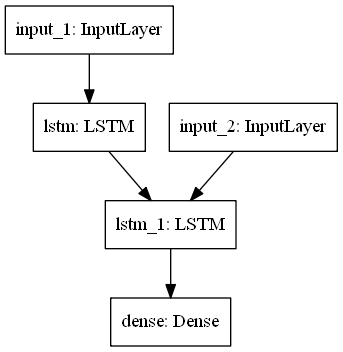

In [28]:
import pydotplus as pydot

tf.keras.utils.plot_model(model)

We define a custon callback to save the model weights at the end of each epoch

In [23]:
class EpochSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        model_dir = os.path.join(debug_dir, "model")
        self.model.save(os.path.join(model_dir, f"simpleLSTM_{epoch}.h5"))

Training/weight loading routine. We use RMSprop optimizer with the default settings and Categorial Cross-entropy loss

In [24]:
if RETRAIN:
    saver = EpochSaver()

    model.compile(
        optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    history = model.fit(
        [encoder_input_data, decoder_input_data],
        decoder_target_data,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.11,
        callbacks=[saver],
    )
    # Save model and training history
    model.save(os.path.join(model_dir, "simpleLSTM_final.h5"))
    np.save(os.path.join(history_dir, "simpleLSTM_history.npy"),history)

else:
    print('Loading model from disk')
    model = keras.models.load_model((os.path.join(model_dir, "simpleLSTM_final.h5")))
    history=np.load(os.path.join(history_dir, "simpleLSTM_history.npy"),allow_pickle=True).item()

Loading model from disk


We plot the training and validation loss over 10 epochs. 

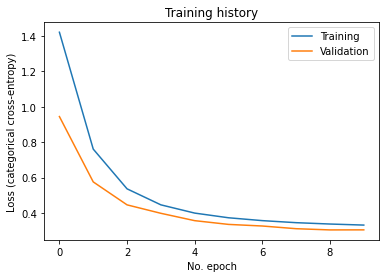

In [26]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Training history')
plt.ylabel('Loss (categorical cross-entropy)')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

With this training we observe no signs of overfitting (validation loss under training loss and monotonically decreasing)

### Inference

We evaluate the model and recover the predicted sequences for the testing set

In [29]:
model.evaluate([test_input_data, test_dec_input_data], test_target_data) 

20/20 [==============================] - 7s 271ms/step - loss: 0.2903 - accuracy: 0.9121


[0.29027059674263, 0.9120678305625916]

As the output is 1-hot encoded, we apply argmax to recover the index in the discretized values dictionary

In [30]:
pred = model.predict([test_input_data, test_dec_input_data]) 
pred_idx = np.apply_along_axis(np.argmax, 2, pred)

In [31]:
print(pred.shape)
print(pred_idx.shape)

(619, 100, 28)
(619, 100)


We recover the predicted sequence using the inverse search dictionary `ID_to_AU`

In [32]:
pred_seqs = []
for i in range(len(pred_idx)):
    pred_i = pred_idx[i]
    seq_i = []
    for p_i in pred_i:
        seq_i.append(ID_to_AU[p_i])
    pred_seqs.append(np.array(seq_i))

pred_seqs = np.array(pred_seqs)

In [33]:
pred_seqs.shape

(619, 100)

Finally, we plot some predicted sequences alongside with the ground-truth extracted in Lab 1

In [34]:
def plot_sample(number):
    plt.plot(range(SEQ_LEN),pred_seqs[number].ravel().astype('float'), label="Predicted")
    plt.plot(range(SEQ_LEN),test_y[number,:,0].ravel().astype('float'),linestyle='dashed', label="Target")

    plt.title('Testing inference')
    plt.ylabel('AU_0r')
    plt.xlabel('Sequence index')
    plt.legend()
    plt.show()

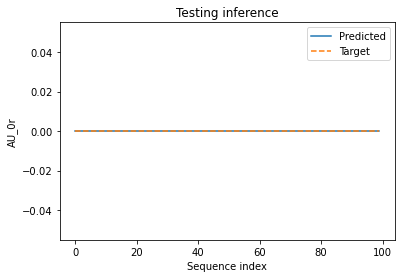

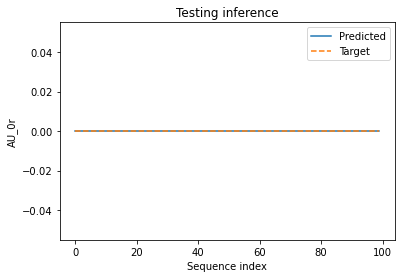

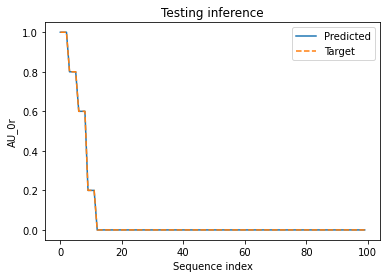

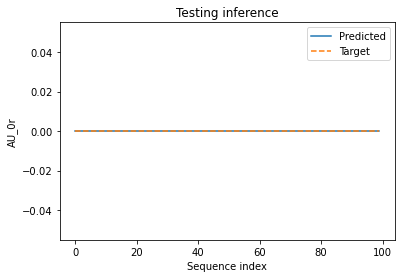

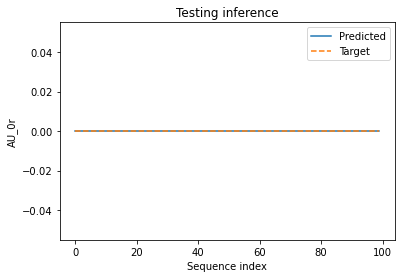

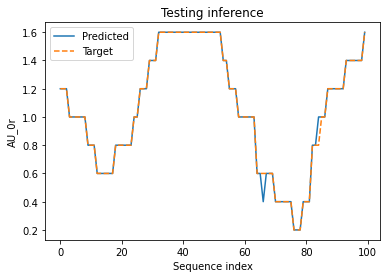

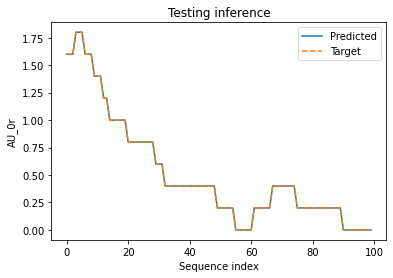

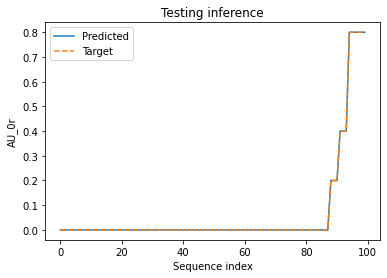

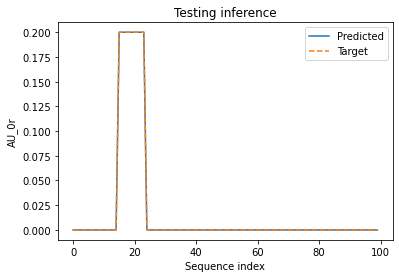

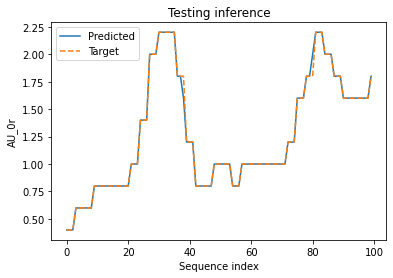

In [35]:
for s in np.random.choice(range(len(pred_seqs)), 10):
    plot_sample(s)

We observe that the model performance is more-than-satisfactory, considering that we only trained for 10 epochs using a vey simple architecture.